In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import DotDict

In [2]:
# Parameters
exp, epoch = 'test', None
test_data = 'test'

if test_data == 'test':
    sample_dim = ['year', 'ens']
    data_dir = '../data/cesm2'
elif test_data == 'real':
    sample_dim = ['year']
    data_dir = '../data/real'

In [3]:
# Read history & hyperparameters
out_dir = f'../output/{exp}'
if epoch is None:
    history = pd.read_csv(f'{out_dir}/history.csv', index_col=0)
    epoch = history['val_mse'].argmin()

with open(f'{out_dir}/hyperparameters.json', 'r') as f:
    hp = json.load(f)
    hp = DotDict(hp)

# Read weights
weight = xr.open_dataset(f'{out_dir}/weight_{test_data}_epoch{epoch}.nc')

# Time-series of weight sum
weight_sum = weight.to_array().sum(dim=['variable', 'lat', 'lon'])

# Normalize weight
weight = weight / weight_sum * 100

In [4]:
# Stack to a sample dimension
weight_stack = weight.stack(sample=sample_dim)

# Sample-mean
weight_mean = weight.mean(dim=sample_dim)

# Contribution of each variable (No grid weighting)
weight_var = weight_mean.sum(dim=['lat', 'lon'])

# Plot

In [5]:
pplt.rc.update({'mathtext.fontset': 'dejavusans', 'mathtext.default': 'it'})

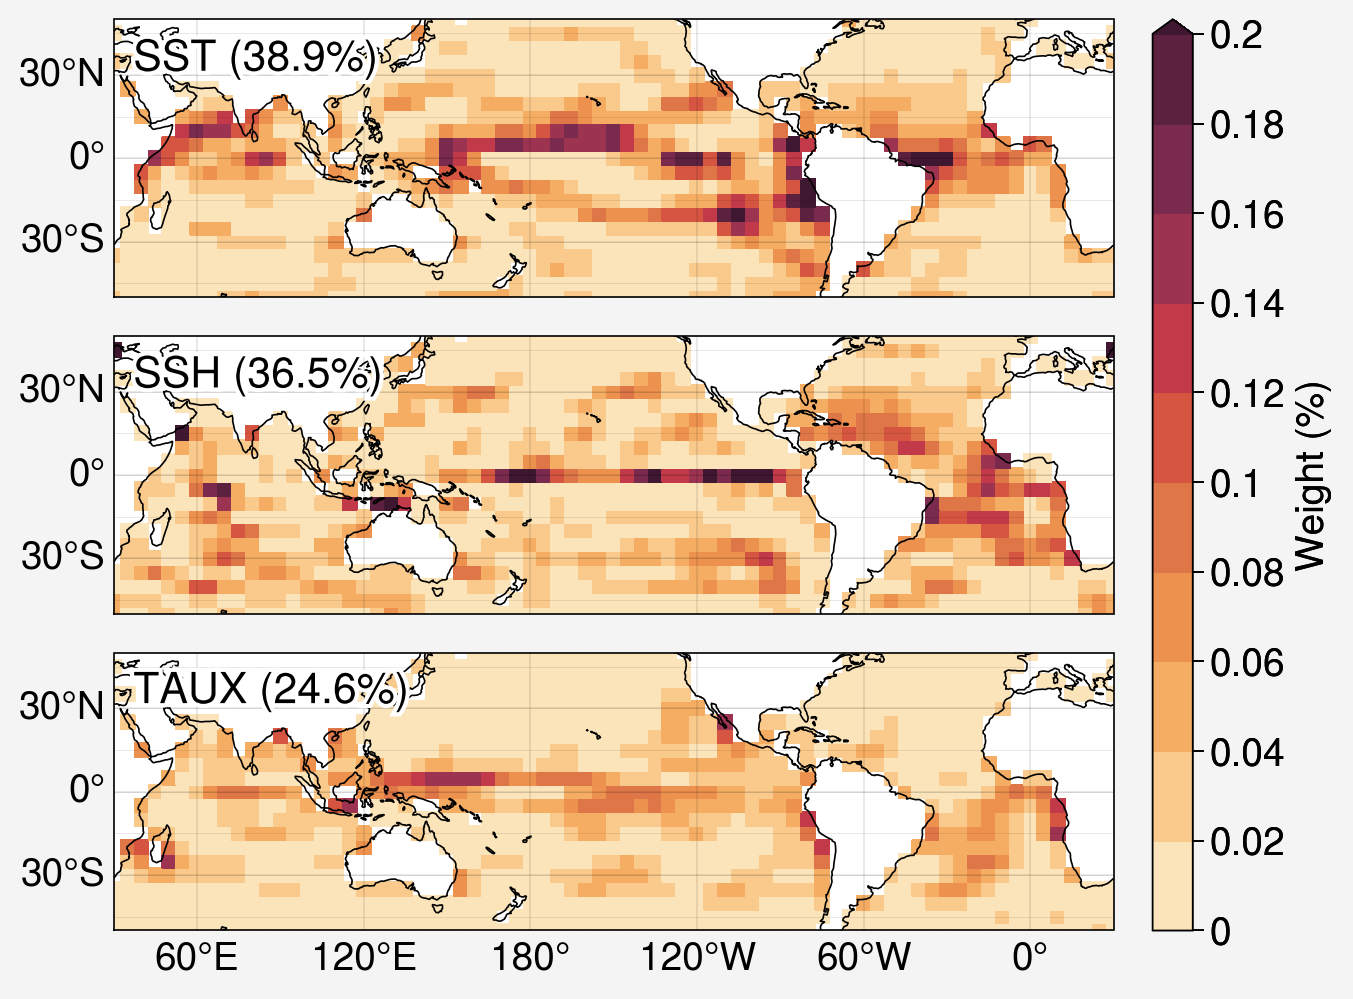

In [6]:
fig, axs = pplt.subplots(nrows=len(hp.vnames), axwidth=5, proj='cyl', proj_kw={'lon_0': 210})

for vname, ax in zip(hp.vnames, axs):
    m = ax.pcolor(weight_mean[vname],
                  levels=np.linspace(0, .2, 11),  
                  extend='max',
                  cmap=pplt.Colormap('fire', left=0.1)
                  )
    ax.format(ultitle=f'{vname.upper()} ({weight_var[vname].data:.1f}%)')
    #ax.colorbar(m)
fig.colorbar(m, label='Weight (%)')
#axs[0].fill([120, 290, 290, 120], [-10, -10, 10, 10], fill=False,
#            transform=ccrs.PlateCarree())
axs.format(
    coast=True, 
    latlim=hp.lat_slice, 
    latlocator=30,
    latgridminor=True,
    latminorlocator=15,
)
axs[-1,:].format(lonlabels=True)
axs[:,0].format(latlabels=True)